This file is part of MADIP: Molecular Atlas Data Integration Pipeline

This file performs normalization

Copyright 2021 Blue Brain Project / EPFL 

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
   

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy.random import randint

from matplotlib import pyplot as plt
import seaborn as sns

import re
import pickle as pkl

import scipy.stats as st

from matplotlib.cbook import boxplot_stats

from scipy.stats import ks_2samp
from scipy.stats import levene
from scipy.stats import kruskal

import scikit_posthocs as sp

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid',{'axes.grid':False})

In [ ]:
# load data from 4_cleanMetadata.ipynb

with open('../data/4_df_agecat.pkl','rb') as f:
    df = pkl.load(f)
print(len(df))


### Normalization

In [ ]:
# sort entries by studies in required order

custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}  

df = df.iloc[df['Study'].map(custom_dict).argsort()]
df = df.reset_index(drop=True)

In [ ]:
df['compound_gene_protein_id'] = df['gene_id_final'] +"#"+ df['Uniprot_final']

df['row_id'] = df['compound_gene_protein_id'] +"@"+ df['sample_full_id']

df['row_gene_id'] = df['gene_id_final'] +"@"+ df['sample_full_id']

In [7]:
df2 = df.drop_duplicates(subset=['row_id','compound_gene_protein_id','sample_full_id','Study','raw_data'],keep='first').reset_index(drop=True) #.unique()

df2g = df.drop_duplicates(subset=['row_gene_id','gene_id_final','sample_full_id','Study','raw_data'],keep='first').reset_index(drop=True) #.unique()

print(len(df2))
print(len(df2g))
print(len(df))

dt = df2[['gene_id_final','row_id','compound_gene_protein_id','sample_full_id','Study']].copy()
dtg = df2[['gene_id_final','row_gene_id','sample_full_id','Study']].copy()


dd = dt[dt.duplicated(keep=False)].sort_values(['row_id','compound_gene_protein_id','sample_full_id','Study'], ascending=[True,True,True,True])
ddg = dtg[dtg.duplicated(keep=False)].sort_values(['row_gene_id','gene_id_final','sample_full_id','Study'], ascending=[True,True,True,True])

print(len(dd)) 

print(len(df.loc[df['row_id'].isin(dd['row_id'].unique()),'gene_names'].unique()))
print(len(df.loc[df['row_gene_id'].isin(ddg['row_gene_id'].unique()),'gene_names'].unique()))

df_fgn = df[['gene_id_final','Study']].copy()

df_fgn_gene_id_final_counts = df_fgn.groupby('gene_id_final').count()

df_fgn_gene_id_final_counts['sum'] = df_fgn_gene_id_final_counts.sum(axis=1)

df_fgn_gene_id_final_counts_dict = pd.Series(df_fgn_gene_id_final_counts['sum'].values,index=df_fgn_gene_id_final_counts.index).to_dict() 

df_fgn2 = df[['Uniprot_final','Study']].copy()

df_fgn_uniprot_final_counts = df_fgn2.groupby('Uniprot_final').count()

df_fgn_uniprot_final_counts['sum'] = df_fgn_uniprot_final_counts.sum(axis=1)

df_fgn_uniprot_final_counts_dict = pd.Series(df_fgn_uniprot_final_counts['sum'].values,index=df_fgn_uniprot_final_counts.index).to_dict() 

2131798
2131797
2131942
42078
946
1404


In [8]:
def deduplicate_gn_uni(idx,row):
    gns = list()
    gns_new = list()
    
    uniprots = list()
    uniprots_new = list()
    
    if isinstance(row['gene_names'],str):
        if (';' in row['gene_names']):
            for elem in row['gene_names'].split(';'):
                if df_fgn_gene_id_final_counts_dict.get(elem,"NotFoundInDict") != 'NotFoundInDict':
                    if (~(elem +"@"+ row['sample_full_id'] in df['row_gene_id'].unique())):
                        return elem
                        
                        
                    else:
                        gns.append(elem)
                else:
                    gns_new.append(elem)
            
            gns_new = [x for x in gns_new if not None]
            gns = [x for x in gns if not None]
            
            if len(gns_new)>0:        
                return gns_new[0]
            elif len(gns)>0:        
                return gns[0]
                    
                
        else:
            return row['gene_names']
                    
    
    else:
        #print("attention ",idx)
        
        if isinstance(row['Uniprot'],str):

            if (';' in row['Uniprot']):
                for elem in row['Uniprot'].split(';'):
                    if df_fgn_uniprot_final_counts_dict.get(elem,"NotFoundInDict") != 'NotFoundInDict':
                        if (~(row['gene_id_final'] +"#"+  elem +"@"+ row['sample_full_id'] in df['row_id'].unique())):
                            return  "attention"+"#"+elem


                        else:
                            uniprots.append(elem)
                    else:
                        uniprots_new.append(elem)

                uniprots_new = [x for x in uniprots_new if not None]
                uniprots = [x for x in uniprots if not None]

                if len(uniprots_new)>0:        
                    return "attention"+"#"+uniprots_new[0]
                elif len(uniprots)>0:        
                    return "attention"+"#"+uniprots[0]

                
            else:
                return "attention"+"#"+row['Uniprot']
            
        else:
            return "check_this_entry"

In [9]:
df4ids = df[['gene_names', 'Uniprot', 'gene_name_unified', 'Uniprot_unified',
       'gene_id_final',  'Uniprot_final',
       'sample_full_id','row_id','row_gene_id']].copy()

df4ids = df4ids.drop_duplicates(keep='first')

df4ids = df4ids.reset_index(drop=True)

print(len(df4ids.loc[df4ids['row_gene_id'].isin(ddg['row_gene_id'].unique())]))


58892


In [10]:
print(len(df4ids.loc[~df4ids['row_gene_id'].isin(ddg['row_gene_id'].unique())]))


2073050


In [9]:
df['gene_id_dd'] = None

for idx,row in df.loc[df['row_gene_id'].isin(ddg['row_gene_id'].unique())].iterrows():
    df.loc[idx,'gene_id_dd'] = deduplicate_gn_uni(idx,row)
    if ((idx % 10000 )==0):
        print(idx)

10000
840000
960000
1440000
1470000
1960000


In [12]:
df.loc[df['row_gene_id'].isin(ddg['row_gene_id'].unique())].head()

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,TheorPepNum,conc_uM,log_conc_uM,copyNum,totalProtein,totalVolume,sample_full_id,compound_gene_protein_id,row_id,row_gene_id,gene_id_dd
170,SERBP1,Q9CY58;Q3UMP4;A0A0N4SV32;Q9CY58-4,Itzhak 2017,mouse,large protein complex,embr,15,NaN,NaN,44.714,250.760031,Median cellular concentration [nM],SERBP1,Q9CY58,SERBP1,5.524496,"[Q6AXS5, Q8NC51, Q9CY58]",Q9CY58,None,0.25076,-1.383259,None,None,None,Itzhak 2017_mouse_large protein complex_15_nan...,SERBP1#Q9CY58,SERBP1#Q9CY58@Itzhak 2017_mouse_large protein ...,SERBP1@Itzhak 2017_mouse_large protein complex...,SERBP1
172,SERBP1,Q9CY58-2;Q9CY58-3,Itzhak 2017,mouse,large protein complex,embr,15,NaN,NaN,42.944,4483.937667,Median cellular concentration [nM],SERBP1,Q9CY58,SERBP1,8.408257,"[Q6AXS5, Q8NC51, Q9CY58]",Q9CY58,None,4.48394,1.500502,None,None,None,Itzhak 2017_mouse_large protein complex_15_nan...,SERBP1#Q9CY58,SERBP1#Q9CY58@Itzhak 2017_mouse_large protein ...,SERBP1@Itzhak 2017_mouse_large protein complex...,SERBP1
249,DOCK11,A2AF67,Itzhak 2017,mouse,subcellular not specified,embr,15,NaN,NaN,218.24,0.043733,Median cellular concentration [nM],DOCK11,A2AF47,DOCK11,-3.129652,"[Q5JSL3, A2AF47]",A2AF47,None,4.3733e-05,-10.037407,None,None,None,Itzhak 2017_mouse_subcellular not specified_15...,DOCK11#A2AF47,DOCK11#A2AF47@Itzhak 2017_mouse_subcellular no...,DOCK11@Itzhak 2017_mouse_subcellular not speci...,DOCK11
250,DOCK11,A2AF65,Itzhak 2017,mouse,subcellular not specified,embr,15,NaN,NaN,61.047,0.715648,Median cellular concentration [nM],DOCK11,A2AF47,DOCK11,-0.334567,"[Q5JSL3, A2AF47]",A2AF47,None,0.000715648,-7.242323,None,None,None,Itzhak 2017_mouse_subcellular not specified_15...,DOCK11#A2AF47,DOCK11#A2AF47@Itzhak 2017_mouse_subcellular no...,DOCK11@Itzhak 2017_mouse_subcellular not speci...,DOCK11
349,PITPNC1,Q8K4R4-2,Itzhak 2017,mouse,subcellular not specified,embr,15,NaN,NaN,31.772,13.835509,Median cellular concentration [nM],PITPNC1,Q8K4R4,PITPNC1,2.627238,"[Q9UKF7, Q8K4R4]",Q8K4R4,None,0.0138355,-4.280517,None,None,None,Itzhak 2017_mouse_subcellular not specified_15...,PITPNC1#Q8K4R4,PITPNC1#Q8K4R4@Itzhak 2017_mouse_subcellular n...,PITPNC1@Itzhak 2017_mouse_subcellular not spec...,PITPNC1


In [18]:
df.loc[(df['Study']=='Hasan 2020')&(df['gene_id_final']=='AARS')&(df['location']=='cerebellum')&(df['sample_id']=='EAE1') ].head()

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,TheorPepNum,conc_uM,log_conc_uM,copyNum,totalProtein,totalVolume,sample_full_id,compound_gene_protein_id,row_id,row_gene_id,gene_id_dd
301116,NaN,Q3UD67,Hasan 2020,mouse,cerebellum,mature adult,156,EAE,EAE1,106.909,19659.7,tmt abundance,None,Q8BGQ7,AARS,9.886326,"[P49588, P50475, Q8BGQ7]",Q8BGQ7,69,1.27744,0.244854,769290,200,1000,Hasan 2020_mouse_cerebellum_156_EAE_EAE1,AARS#Q8BGQ7,AARS#Q8BGQ7@Hasan 2020_mouse_cerebellum_156_EA...,AARS@Hasan 2020_mouse_cerebellum_156_EAE_EAE1,attention#Q3UD67
392325,NaN,Q3TZ32,Hasan 2020,mouse,cerebellum,mature adult,156,EAE,EAE1,106.909,147.4,tmt abundance,None,Q8BGQ7,AARS,4.993150,"[P49588, P50475, Q8BGQ7]",Q8BGQ7,69,0.00957766,-4.648322,5767.8,200,1000,Hasan 2020_mouse_cerebellum_156_EAE_EAE1,AARS#Q8BGQ7,AARS#Q8BGQ7@Hasan 2020_mouse_cerebellum_156_EA...,AARS@Hasan 2020_mouse_cerebellum_156_EAE_EAE1,attention#Q3TZ32


In [ ]:
# Q3UD67 and Q3TZ32 - both unreviewed, same gene AARS, same info on Uniprot

In [24]:
len(df.loc[df['gene_id_dd'].isna()])

2073050

In [13]:
len(df.loc[~df['gene_id_dd'].isna()])

58892

In [25]:
len(df.loc[~df['gene_id_dd'].isna()])/len(df.loc[df['gene_id_dd'].isna()])

0.028408383782349677

In [14]:
len(df.loc[df['gene_id_dd']=='check_this_entry'])

0

In [15]:
len(df.loc[(~df['gene_id_dd'].isna())&(df['gene_id_dd'].str.contains('attention'))])

18822

In [26]:
print(len(dd)/len(df)) 

0.019736934682087974


In [27]:
len(dd.loc[(~dd['gene_id_final'].isna())& (~dd['gene_id_final'].isnull()) ,'gene_id_final'].unique())

1045

In [24]:
len(df2.loc[(df2['compound_gene_protein_id'].isin(dd['compound_gene_protein_id'].unique())) & \
            (df2['sample_full_id'].isin(dd['sample_full_id'].unique())) &(~df2['gene_names'].isna())& \
            (~df2['gene_names'].isnull()) ,'gene_id_final'].unique())


1043

In [28]:
df = df.reset_index(drop=True)

In [30]:
with open('../data/5_1_df_markDup_10May2021.pkl','wb') as f:
    pkl.dump(df,f)

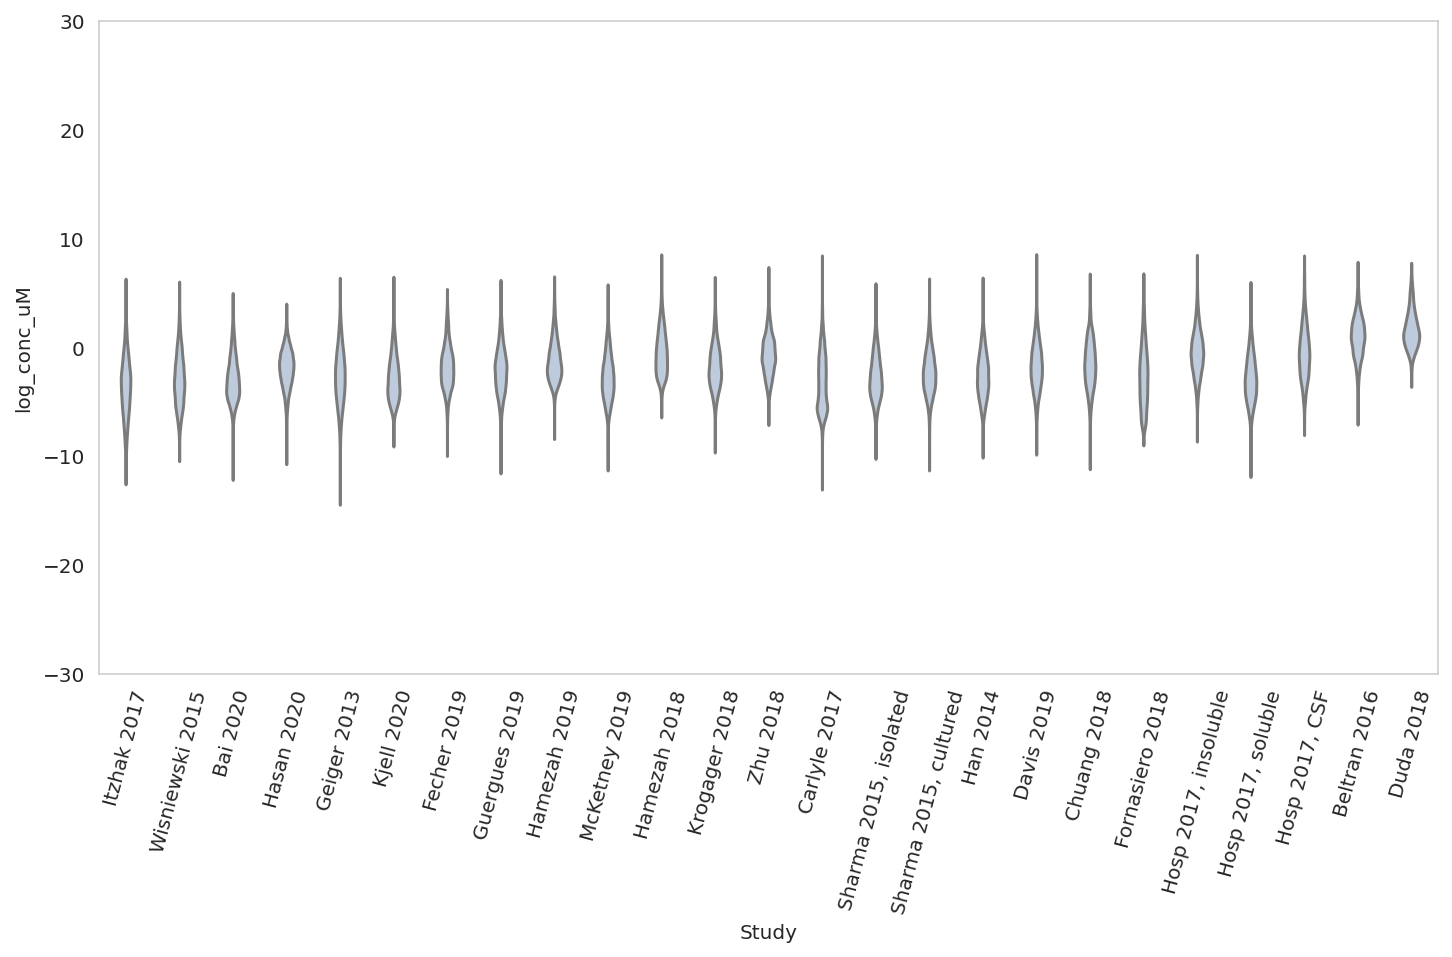

In [31]:
fig = plt.figure(figsize=(12, 6))

ax = sns.violinplot(x="Study", y="log_conc_uM", data=df, inner=None,dodge=False, width=0.3,color='#b8cbe1', zorder=1 ) #, fliersize=2)


ax.grid(False)
plt.xticks(rotation=75)
ax.set_ylabel('log_conc_uM')


plt.ylim([-30,30])


plt.show()


In [32]:
df['condition'].unique()

array([nan, 'AD', 'LPC: low pathology of plaques and tangles. AD',
       'control',
       'AD: late-stage AD with high pathology scores of plaques and tangles',
       'PSP: progressive supranuclear palsy, another neurodegenerative disorder of tauopathy',
       'HPC: high Ab pathology but no detectable cognitive defects. AD',
       'MCI: mild cognitive impairment with Ab pathology and a slight but measurable defect in cognition. AD',
       'EAE', 'Alzheimer', 'WT', 'AD_intermediate', 'AD_severe', 'SORT',
       'adult', 'young'], dtype=object)

In [33]:
df_stat = df[['log_conc_uM','Study']].groupby(['Study']).describe()


custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}  



df_stat = df_stat.iloc[df_stat.index.map(custom_dict).argsort()]

df_stat = df_stat.reset_index()

df_stat

Study log_conc_uM                                 \
                                count      mean       std        min   
0             Itzhak 2017      9019.0 -3.574031  2.634868 -11.746833   
1         Wisniewski 2015     19508.0 -2.990055  2.355982  -9.813204   
2                Bai 2020    242008.0 -2.850197  2.025065 -11.853548   
3              Hasan 2020    260202.0 -1.904118  1.754050 -10.454866   
4             Geiger 2013     24722.0 -2.678293  2.496064 -13.814960   
5              Kjell 2020     94128.0 -2.776824  2.068386  -8.697280   
6             Fecher 2019    128733.0 -1.777524  1.963697  -9.615706   
7           Guergues 2019     14013.0 -2.110201  2.133245 -10.964717   
8            Hamezah 2019     11564.0 -1.201468  1.852353  -7.857028   
9           McKetney 2019    191456.0 -2.718276  2.067121 -10.958957   
10           Hamezah 2018      8720.0 -0.448525  2.038547  -5.785247   
11          Krogager 2018      4414.0 -1.748781  2.010158  -8.925834   
12               Zhu 2018     13200.0 -0.691595  1.868645  -6.582196   
13           Carlyle 2017    363748.0 -3.134417  2.561117 -12.683718   
14  Sharma 2015, isolated    142430.0 -2.708684  2.046121  -9.881729   
15  Sharma 2015, cultured    167579.0 -2.288380  1.966163 -10.965412   
16               Han 2014     56202.0 -2.537255  2.091922  -9.675219   
17             Davis 2019     32696.0 -1.674276  2.167604  -9.326251   
18            Chuang 2018     10552.0 -1.533945  2.151207 -10.534245   
19        Fornasiero 2018      1651.0 -2.606201  2.777497  -7.749452   
20   Hosp 2017, insoluble     32466.0 -0.472751  2.062751  -8.150127   
21     Hosp 2017, soluble    293790.0 -2.833536  2.137521 -11.581159   
22         Hosp 2017, CSF      4916.0 -0.537517  2.336171  -7.213443   
23           Beltran 2016      2389.0  0.960509  1.854870  -6.328920   
24              Duda 2018      1138.0  1.656080  1.699159  -2.803087   

                                            
         25%       50%       75%       max  
0  -5.410533 -3.516066 -1.768979  5.473066  
1  -4.738661 -3.111072 -1.375348  5.395629  
2  -4.336174 -3.087313 -1.559628  4.665113  
3  -3.060130 -1.820813 -0.665333  3.732447  
4  -4.404753 -2.692309 -0.949276  5.742239  
5  -4.351806 -3.000416 -1.418040  6.081400  
6  -3.173269 -1.889410 -0.534319  4.998807  
7  -3.596309 -2.124881 -0.704798  5.575077  
8  -2.576463 -1.456766 -0.052499  5.960968  
9  -4.220339 -2.855011 -1.350261  5.435532  
10 -2.042931 -0.650802  0.930166  7.894965  
11 -3.183549 -1.918666 -0.443702  5.730001  
12 -1.998296 -0.750087  0.550875  6.834091  
13 -5.308766 -3.325143 -1.184685  8.063418  
14 -4.184818 -2.887714 -1.324972  5.520212  
15 -3.682358 -2.390941 -0.963766  5.982338  
16 -4.052269 -2.622424 -1.109754  5.956336  
17 -3.194790 -1.752174 -0.221445  8.036255  
18 -3.060550 -1.572190  0.007728  6.115131  
19 -4.790390 -2.703557 -0.720543  5.552611  
20 -1.865331 -0.510470  0.862461  7.995532  
21 -4.376968 -2.978435 -1.391548  5.673179  
22 -2.226603 -0.636368  1.026928  7.600704  
23 -0.296585  0.998348  2.213565  7.089637  
24  0.429010  1.404389  2.677055  6.955096

In [34]:
commonMed = np.median(df_stat['log_conc_uM']['50%'].values)

commonMed

-2.124881208395103

In [35]:
# housekeeping genes mouse: http://www.housekeeping.unicamp.br/?download bioRxiv preprint doi: https://doi.org/10.1101/787150 

mhg = pd.read_csv('../data/Mouse_HK_genes.csv')

mhg['Gene'] = mhg['Gene'].str.upper()

mhg.head()

,Gene,Ensembl ID,Transcript start,Transcript end,Chromosome_scaffold
0,0610009B22RIK,ENSMUST00000007921,51685386,51688653,11
1,0610030E20RIK,ENSMUST00000077783,72347334,72353148,6
2,0610030E20RIK,ENSMUST00000192144,72347333,72353147,CHR_MG184_PATCH
3,0610037L13RIK,ENSMUST00000125107,107889899,107897802,4
4,0610037L13RIK,ENSMUST00000106727,107889863,107897118,4


In [36]:
len(mhg['Gene'].unique())

3277

In [37]:
df_mhg = df.loc[df['gene_id_final'].isin(mhg['Gene'].unique())].copy()
len(df_mhg)

639650

In [38]:
len(df_mhg['Study'].unique())

25

In [39]:
#find most frequent proteins and less variable proteins

dfg = df[['log_conc_uM','Study','gene_id_final']].groupby(['Study','gene_id_final']).describe()


In [40]:
dfg = dfg.reset_index()

In [42]:
dfgmhg = dfg.loc[dfg['gene_id_final'].isin(mhg['Gene'].unique())].copy()
len(dfgmhg)

38049

In [43]:
len(dfgmhg['gene_id_final'].unique())

3110

In [44]:
df_mhg.columns

Index(['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
       'gene_id_final', 'log_raw_data', 'uniprot_from_gn', 'Uniprot_final',
       'TheorPepNum', 'conc_uM', 'log_conc_uM', 'copyNum', 'totalProtein',
       'totalVolume', 'sample_full_id', 'compound_gene_protein_id', 'row_id',
       'row_gene_id', 'gene_id_dd'],
      dtype='object')

In [45]:
df_mhg['condition'].unique()

array([nan, 'AD', 'LPC: low pathology of plaques and tangles. AD',
       'HPC: high Ab pathology but no detectable cognitive defects. AD',
       'PSP: progressive supranuclear palsy, another neurodegenerative disorder of tauopathy',
       'AD: late-stage AD with high pathology scores of plaques and tangles',
       'MCI: mild cognitive impairment with Ab pathology and a slight but measurable defect in cognition. AD',
       'control', 'EAE', 'Alzheimer', 'WT', 'AD_intermediate',
       'AD_severe', 'SORT', 'young', 'adult'], dtype=object)

In [46]:
df['condition'].unique()

array([nan, 'AD', 'LPC: low pathology of plaques and tangles. AD',
       'control',
       'AD: late-stage AD with high pathology scores of plaques and tangles',
       'PSP: progressive supranuclear palsy, another neurodegenerative disorder of tauopathy',
       'HPC: high Ab pathology but no detectable cognitive defects. AD',
       'MCI: mild cognitive impairment with Ab pathology and a slight but measurable defect in cognition. AD',
       'EAE', 'Alzheimer', 'WT', 'AD_intermediate', 'AD_severe', 'SORT',
       'adult', 'young'], dtype=object)

In [48]:
df_mhg['Age_cat'].unique()

array(['embr', 'adult', 'mature adult', 'post-mortem', 'middle-aged',
       'old', 'young', 'child', 'adolescence'], dtype=object)

In [49]:
df_mhg['location'].unique()

array(['actin binding proteins', 'plasma membrane',
       'subcellular not specified', 'large protein complex', 'er',
       'mitochondria', 'golgi', 'endosome', 'nucleus', 'lysosome',
       'peroxisome', 'brain', 'cortex', 'hippocampus', 'striatum',
       'spinal cord', 'brainstem', 'cerebellum', 'midbrain',
       'olfactory bulb', 'medulla', 'subependymal zone',
       'medial subependymal zone', 'microglia', 'thalamus', 'amygdala',
       'neurons', 'corpus callosum', 'astrocytes', 'oligodendrocytes',
       'optic nerve', 'axon', 'csf', 'cytoplasm'], dtype=object)

In [50]:
len(df_mhg.loc[(df_mhg['condition'].isna())])

434769

In [51]:
df_stat2 = df_mhg.loc[((df_mhg['condition'].isin(['control','WT','SORT', 'adult', 'young'])) | 
                       (df_mhg['condition'].isna())) & (df_mhg['Organism']=='mouse')&
                      (df_mhg['Age_cat'].isin(['embr','young','adult', 'mature adult','middle-aged']))& 
                      (df_mhg['Study']!='Fecher 2019'),['log_conc_uM','Study']].groupby(['Study']).describe()


custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}  



df_stat2 = df_stat2.iloc[df_stat2.index.map(custom_dict).argsort()]

df_stat2 = df_stat2.reset_index()

df_stat2

Study log_conc_uM                                 \
                                count      mean       std        min   
0             Itzhak 2017      2994.0 -2.755689  2.383091 -10.923798   
1         Wisniewski 2015      5603.0 -2.829793  2.201288  -9.813204   
2                Bai 2020     21160.0 -2.639715  1.807188  -7.700293   
3              Hasan 2020     38568.0 -1.728067  1.630595  -9.307307   
4             Geiger 2013      7648.0 -2.485414  2.330253 -10.553649   
5              Kjell 2020     29376.0 -2.723036  1.901825  -7.820844   
6           Guergues 2019      5887.0 -1.968306  1.973884  -8.539880   
7            Hamezah 2019      1791.0 -1.431116  1.580731  -4.964267   
8           Krogager 2018      1434.0 -1.906829  1.816301  -7.111528   
9   Sharma 2015, isolated     43046.0 -2.359960  1.882640  -8.444207   
10  Sharma 2015, cultured     56352.0 -1.939981  1.809360 -10.944333   
11               Han 2014     20960.0 -2.330744  1.960838  -9.214843   
12        Fornasiero 2018       575.0 -2.990518  2.519221  -7.525322   
13   Hosp 2017, insoluble      9440.0 -0.669984  1.931837  -7.872273   
14     Hosp 2017, soluble     86732.0 -2.643869  1.995114 -10.116697   
15         Hosp 2017, CSF       945.0 -0.881215  2.185183  -7.109382   
16              Duda 2018       240.0  1.147192  1.436252  -2.599001   

                                            
         25%       50%       75%       max  
0  -4.313887 -2.642314 -1.089321  3.844481  
1  -4.436213 -2.757105 -1.237803  4.361808  
2  -4.036123 -2.798117 -1.352052  3.257621  
3  -2.772626 -1.588807 -0.552499  3.332178  
4  -4.072600 -2.419146 -0.818156  4.564067  
5  -4.164949 -2.874920 -1.443385  5.233592  
6  -3.323568 -1.905077 -0.588730  3.911852  
7  -2.565219 -1.653823 -0.604810  5.024790  
8  -3.190251 -2.032461 -0.690381  5.186267  
9  -3.741537 -2.429602 -1.017558  4.016700  
10 -3.249561 -2.014671 -0.682669  4.514092  
11 -3.755806 -2.308907 -0.966570  3.651303  
12 -4.951078 -3.021306 -1.408006  4.986430  
13 -1.995185 -0.668241  0.613259  5.784888  
14 -4.078433 -2.660763 -1.236066  4.805379  
15 -2.461911 -0.854334  0.549315  4.654205  
16  0.198193  1.004681  1.905808  5.748415

In [52]:
# comm med mouse age cat housekeeping genes condition

commonMedMain = np.median(df_stat2['log_conc_uM']['50%'].values)

commonMedMain

-2.3089067812917943

In [53]:
df['log_conc_uM_medNorm'] = None

In [54]:
for study in df['Study'].unique():
    df.loc[df['Study']==study,'log_conc_uM_medNorm'] = df.loc[df['Study']==study,'log_conc_uM']  -  df_stat.loc[df_stat['Study']==study,'log_conc_uM']['50%'].values[0] + commonMedMain
    
    

In [56]:
with open('../data/5_2_df_commMedMouseHKG_10May2021.pkl','wb') as f:
    pkl.dump(df,f)

In [57]:
df.loc[df['location']=='mitochondria','Study'].unique()

array(['Itzhak 2017', 'Fecher 2019', 'Beltran 2016'], dtype=object)

In [ ]:
# do not replace condiiton names as may lead to duplicates
# df.loc[(df['condition'].isin(['WT','control', 'SORT','young', 'adult']) | (df['condition'].isna())),'condition' ] = "control"

In [ ]:
with open('../data/5_2_df_commMedMouseHKG.pkl','rb') as f:
    df = pkl.load(f)
print(len(df))
df["log_conc_uM_medNorm"]  = df["log_conc_uM_medNorm"].astype('float64')

custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}   



df = df.iloc[df['Study'].map(custom_dict).argsort()]
df = df.loc[~df['log_conc_uM'].isna()]

df = df.reset_index(drop=True)

with open('../data/6_df_processed_10May2021.pkl','wb') as f:
    pkl.dump(df,f)

In [ ]:
df_sort = df.drop(columns=['gene_names', 'gene_name_unified', 'Uniprot', 'Uniprot_unified','Age_days','sample_id',
                          'molecular_weight_kDa', 'raw_data', 'raw_data_units',
                          'uniprot_from_gn','Uniprot_final', 'TheorPepNum', 'conc_uM', 'log_conc_uM',
                          'sample_full_id', 'compound_gene_protein_id','row_id',
                          'row_gene_id', 'gene_id_dd','totalProtein',
                          'totalVolume','copyNum'])



with open('../data/6_df_sort_10May2021.pkl','wb') as f:
    pkl.dump(df_sort,f)